##**Sistem Rekomendasi: Rekomendasi Film untuk Pengguna**

**Oleh** : Alifia Feiling A.S

*Proyek Submission 2 - Machine Learning Terapan Dicoding*

#Pendahuluan

Pada proyek ini akan dibuat sistem rekomendasi untuk memberikan suatu saran rekomendasi kepada pengguna secara efektif dengan Collaborative Filtering.

#**1. Mempersiapkan Dataset**


**1.1. Kredensial akun kaggle**

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!ls ~/.kaggle

kaggle.json


**1.2. Mengunduh dan Mempersiapkan Dataset**

In [7]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle datasets download -d rounakbanik/the-movies-dataset

 92% 210M/228M [00:01<00:00, 163MB/s]
100% 228M/228M [00:01<00:00, 161MB/s]


In [8]:
# Mengekstrak berkas zip ke direktori aktif saat ini
!mkdir film
!unzip -qq /content/the-movies-dataset.zip -d film
!ls film

credits.csv   links.csv        movies_metadata.csv  ratings_small.csv
keywords.csv  links_small.csv  ratings.csv


#**2. Mengimpor pustaka/modul Python**

In [9]:
#untuk pengolahan data
import numpy as np
import pandas as pd

#untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

#untuk pembuatan sistem rekomendasi
!pip install scikit-surprise
import surprise
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader, Dataset
from surprise import KNNBasic

#untuk evaluasi sistem rekomendasi
from surprise import accuracy

     |████████████████████████████████| 11.8 MB 4.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619405 sha256=a0969729db238a697115467a88c2fd8d0a1e30a6448602fa9bcbe34738559eff
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


# **3. Pemahaman Data (Data Understanding)**

## **3.1 Memuat data pada sebuah dataframe menggunakan pandas**

###**3.1.1 Dataset Rating**

In [10]:
rating = pd.read_csv("/content/film/ratings_small.csv")

In [11]:
#pratinjau dataset
rating

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


### **3.1.2 Dataset Judul**

In [12]:
judul = pd.read_csv("/content/film/movies_metadata.csv")
#pratinjau dataset
judul = judul[['title']]
judul

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,title
0,Toy Story
1,Jumanji
2,Grumpier Old Men
3,Waiting to Exhale
4,Father of the Bride Part II
...,...
45461,Subdue
45462,Century of Birthing
45463,Betrayal
45464,Satan Triumphant


###**3.1.3 Menggabungkan dataset rating dan judul**

In [13]:
datafilm = pd.concat([rating, judul], axis=1)
datafilm

,userId,movieId,rating,timestamp,title
0,1,31,2.5,1260759144,Toy Story
1,1,1029,3.0,1260759179,Jumanji
2,1,1061,3.0,1260759182,Grumpier Old Men
3,1,1129,2.0,1260759185,Waiting to Exhale
4,1,1172,4.0,1260759205,Father of the Bride Part II
...,...,...,...,...,...
99999,671,6268,2.5,1065579370,NaN
100000,671,6269,4.0,1065149201,NaN
100001,671,6365,4.0,1070940363,NaN
100002,671,6385,2.5,1070979663,NaN


#**3.2 Keterangan kolom pada dataset**

In [14]:
#memuat informasi dataframe
datafilm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
 4   title      45460 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ MB


In [15]:
#menghitung jumlah data kosong pada setiap kolom
datafilm.isna().sum

<bound method DataFrame.sum of         userId  movieId  rating  timestamp  title
0        False    False   False      False  False
1        False    False   False      False  False
2        False    False   False      False  False
3        False    False   False      False  False
4        False    False   False      False  False
...        ...      ...     ...        ...    ...
99999    False    False   False      False   True
100000   False    False   False      False   True
100001   False    False   False      False   True
100002   False    False   False      False   True
100003   False    False   False      False   True

[100004 rows x 5 columns]>

In [16]:
#memuat deskripsi setiap kolom dataframe
datafilm.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


##**3.3 Visualisasi Data**

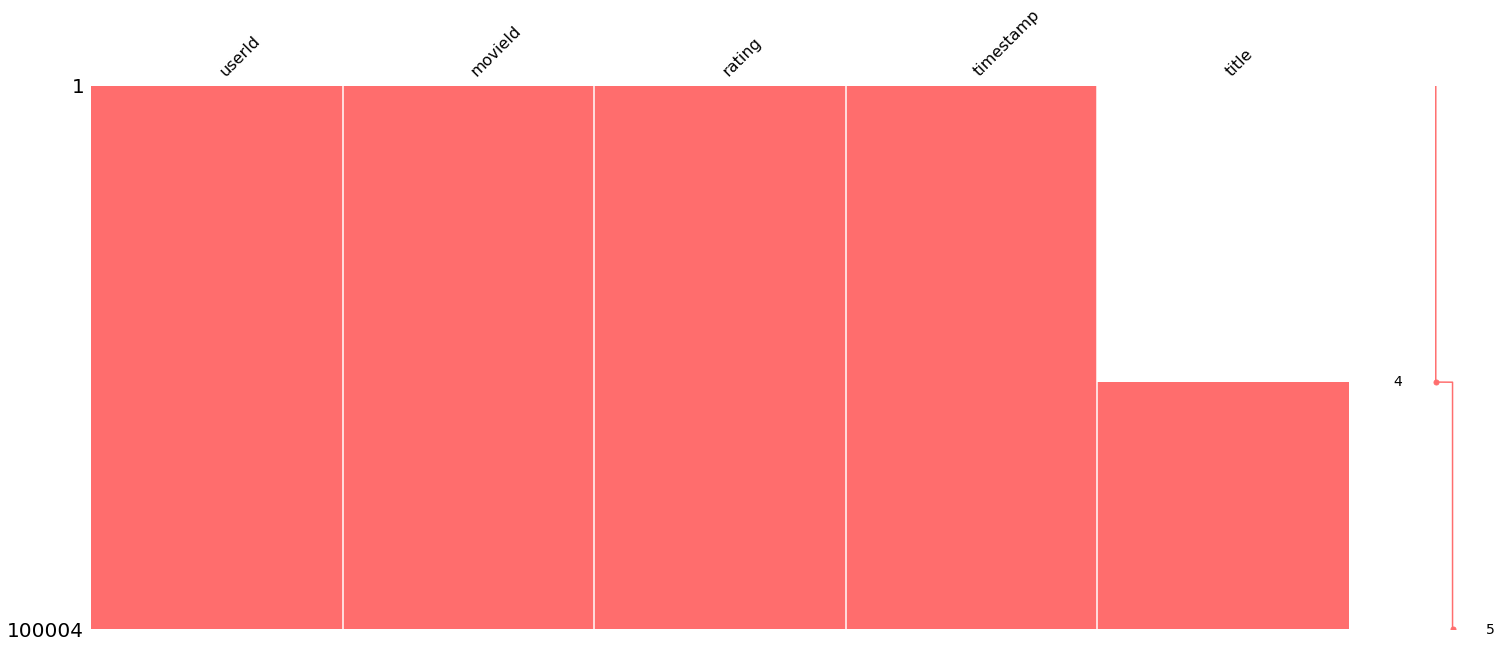

In [17]:
# visualisasi data kosong pada setiap kolom
sorted_null = msno.nullity_sort(datafilm, sort='ascending') 
figures = msno.matrix(sorted_null, color=(1, 0.43, 0.43))

Text(0.5, 1.0, 'Korelasi antar kolom')

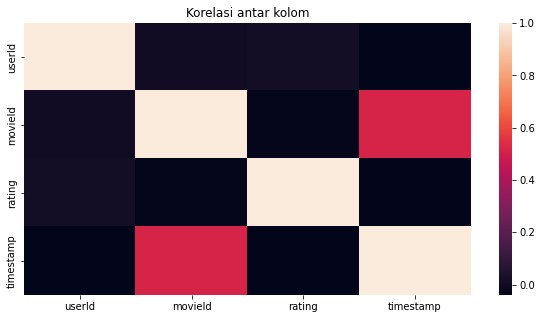

In [18]:
#visualisasi korelasi antar kolom
plt.figure(figsize=(10,5))
sns.heatmap(datafilm.corr());
plt.title("Korelasi antar kolom")

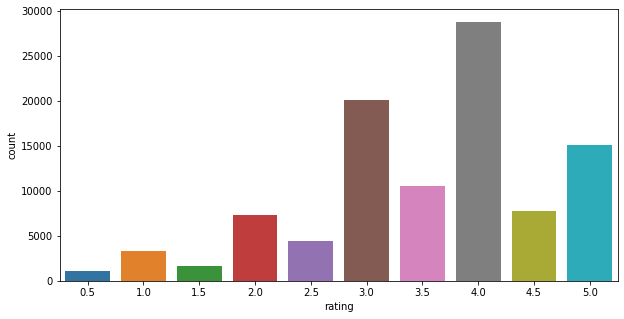

In [19]:
#visualisasi data berdasarkan jumlah rating
ims = (10, 8)
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(x="rating", data=rating)

# **4. Persiapan Data (Data Preparation)**

##**4.1 Kolom dataset untuk framework surprise**

In [20]:
# Dataset yang akan dipakai untuk train test split dengan framework surprise
reader = Reader()
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)


##**4.2 Melakukan pembagian data pada dataset dengan train_test_split**

In [21]:
# Train & Test
trainset, testset = train_test_split(data, test_size=0.20, random_state=50)

# **5. Pembuatan Model**

## **5.1 Pembuatan Model SVD**

In [22]:
# Gunakan fungsi svd() yang sudah disediakan pada surprise
algo_svd = SVD()
prediction_mf = algo_svd.fit(trainset).test(testset)

# Prediksi
prediction_mf

[Prediction(uid=130, iid=1148, r_ui=4.0, est=3.7479234328207474, details={'was_impossible': False}),
 Prediction(uid=468, iid=7153, r_ui=3.5, est=3.2139414889487505, details={'was_impossible': False}),
 Prediction(uid=457, iid=58559, r_ui=0.5, est=2.9132682651750335, details={'was_impossible': False}),
 Prediction(uid=564, iid=3324, r_ui=1.0, est=2.4474522756795056, details={'was_impossible': False}),
 Prediction(uid=77, iid=3753, r_ui=3.5, est=2.918545661003825, details={'was_impossible': False}),
 Prediction(uid=564, iid=1970, r_ui=3.0, est=3.27697210143212, details={'was_impossible': False}),
 Prediction(uid=524, iid=481, r_ui=3.0, est=3.5476767343729154, details={'was_impossible': False}),
 Prediction(uid=105, iid=2247, r_ui=3.0, est=3.1411899713165736, details={'was_impossible': False}),
 Prediction(uid=598, iid=1291, r_ui=4.0, est=3.808831523917602, details={'was_impossible': False}),
 Prediction(uid=46, iid=91529, r_ui=5.0, est=4.9550055681047995, details={'was_impossible': Fals

##**5.2 Pembuatan Model KNN**

In [23]:
#pembuatan model knn
sim_options = {'name': 'pearson_baseline','shrinkage': 0}
algo = KNNBasic(sim_options=sim_options)
algo_knn = KNNBasic(k=75, sim_options=sim_options)
prediction_knn = algo_knn.fit(trainset).test(testset)

# Prediksi
prediction_knn

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


[Prediction(uid=130, iid=1148, r_ui=4.0, est=4.242280088027073, details={'actual_k': 37, 'was_impossible': False}),
 Prediction(uid=468, iid=7153, r_ui=3.5, est=4.100526931541624, details={'actual_k': 73, 'was_impossible': False}),
 Prediction(uid=457, iid=58559, r_ui=0.5, est=3.778791183680525, details={'actual_k': 47, 'was_impossible': False}),
 Prediction(uid=564, iid=3324, r_ui=1.0, est=2.348971861616771, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=77, iid=3753, r_ui=3.5, est=2.9532775592671756, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=564, iid=1970, r_ui=3.0, est=2.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=524, iid=481, r_ui=3.0, est=3.5216498483452745, details={'actual_k': 9, 'was_impossible': False}),
 Prediction(uid=105, iid=2247, r_ui=3.0, est=3.728524750684561, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=598, iid=1291, r_ui=4.0, est=4.153434143383197, details={'actual_k': 75, 

# **6. Pengujian Model**

##**6.1 Pengujian Rekomendasi Model Algo SVD**

In [24]:
#pengujian rekomendasi model algo SVD
recom_svd = algo_svd.predict(uid=1,iid=5)
recom_svd

Prediction(uid=1, iid=5, r_ui=None, est=2.7047926232463517, details={'was_impossible': False})

## **6.2 Pengujian Rekomendasi Model KNN**

In [25]:
# pegujian rekomendasi model KNN
recom_knn = algo_knn.predict(uid=30,iid=5655)
recom_knn

Prediction(uid=30, iid=5655, r_ui=None, est=3.5418984288089197, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

# **6. Evaluasi**

## **6.1 Evaluasi Model Algo SVD**

In [26]:
accuracy.mae(prediction_mf)
accuracy.fcp(prediction_mf)
accuracy.rmse(prediction_mf)

MAE:  0.6816
FCP:  0.6413
RMSE: 0.8843


0.8843361741073843

## **6.2 Evaluasi Model KNN**

In [27]:
accuracy.mae(prediction_knn)
accuracy.fcp(prediction_knn)
accuracy.rmse(prediction_knn)

MAE:  0.7673
FCP:  0.6475
RMSE: 0.9964


0.996383704822061

#**Penutupan** 

Disimpulkan bahwa penggunaan metode collaborative filtering dapat memberikan suatu saran rekomendasi kepada pengguna secara efektif, baik menggunakan algoritma KNN maupun menggunakan matrix factorization. 

### **Referensi**

1. https://scikit-learn.org/stable/modules/classes.html
2. https://plotly.com/python/
3. https://www.kaggle.com/faridrizqis/recommendersystem-colaborativefilter-surprise#Menggunakan-Metode-SVD
4. https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system#Content-Based-Filtering